## Function Approximation using ANFIS

Approximate the function <br> **y=sin(pi.x1/4).sin(pi.x2/4) for -4<=x1,x2<=4** <br>using an ANFIS. Use differential evolution (here, genetic algorithm) for updating the parameters of the ANFIS. Create a video on how the function approximation progress with respect to generations of a differential evolution algorithm.

#### NIC---Assignment-5---
#### Shivji Bhagat --- 16110149

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from GeneticAlgorithmOptimizer import *

In [2]:
## Create Train-Test Data
def func(x1, x2, pi = 3.143):
    y = np.sin(pi*x1/4)*np.sin(pi*x2/4)
    return y


def getData(trainSize=5000, testSize=500, function = func):
    trainX = np.random.uniform(-4,4, size = (trainSize,2))
    testX = np.random.uniform(-4,4, size = (testSize, 2))
    
    trainY = function(trainX[:,0], trainX[:,1])
    testY = function(testX[:,0], testX[:,1])
    return (trainX, trainY, testX, testY)


In [3]:
## create different layers

#membership_functions
def gaussianLayer(x, mu, sigma):
    sigma += 0.000001
    x.reshape(1,-1)
    pi=3.143
    y = (1/np.sqrt(2*pi*sigma**2)) * np.exp((-1/2)*np.power(((x-mu)/sigma),2))
    return y

#multtiplexer
def multiplexLayer(x1, x2):
    assert(x1.shape==x2.shape)
    return x1*x2

#normalizationLayer
def normLayer(w1, w2):
    return w1/(w1+w2+0.00001)

#lineraLayer
def linearLayer(x1, x2, w, p,q,r):
    wfi = w*(p*x1 + q*x2 +r)
    return wfi

#summationLayer
def sumLayer(x1, x2):
    f = x1+x2
    return f



In [4]:
## initialiser
def initialiseParams():
    """
    mus = 4, sigmas = 4, nLinear = 2
    
    initialises the parameters of the ANFIS network
    mus - no. of mu reqd
    sigmas - no. of simas reqd
    nLinear - no.of linear layers reqd.
    return a dict
    """
    
    r1, r2 = 0,0
    p1,p2,q1,q2 = np.around(np.random.rand(4)*2-1, 2)
    
    mu1, mu2, mu3, mu4 = np.around(np.random.rand(4)*2-1, 2)
    sigma1, sigma2, sigma3, sigma4 = np.around(np.random.rand(4)*2-1, 2)
    
    mus = [mu1, mu2, mu3, mu4]
    sigmas = [sigma1, sigma2, sigma3, sigma4]
    linears = [p1, q1, r1, p2, q2, r2]
    
    params = {"mus":mus, "sigmas":sigmas, "linears":linears}
    return params
def convertParams2list(params):
    mu1, mu2, mu3, mu4 = params["mus"]
    sigma1, sigma2, sigma3, sigma4 = params["sigmas"]
    p1, q1, r1, p2, q2, r2 = params["linears"]
    return np.array([mu1, mu2, mu3, mu4, sigma1, sigma2, sigma3, sigma4,p1, q1, r1, p2, q2, r2])
def convertParams2dic(params):
    mu1, mu2, mu3, mu4, sigma1, sigma2, sigma3, sigma4,p1, q1, r1, p2, q2, r2 = params
    
    mus = [mu1, mu2, mu3, mu4]
    sigmas = [sigma1, sigma2, sigma3, sigma4]
    linears = [p1, q1, r1, p2, q2, r2]
    
    params = {"mus":mus, "sigmas":sigmas, "linears":linears}
    return params

In [5]:
def forwardPropagation(x1, x2, params):
    #get the parameters from the dictionary
    mu1, mu2, mu3, mu4 = params["mus"]
    sigma1, sigma2, sigma3, sigma4 = params["sigmas"]
    p1, q1, r1, p2, q2, r2 = params["linears"]
    
    #membership_function_layer
    x1A1 = gaussianLayer(x1, mu1, sigma1)
    x1A2 = gaussianLayer(x1, mu2, sigma2)
    x2B1 = gaussianLayer(x2, mu3, sigma3)
    x2B2 = gaussianLayer(x2, mu4, sigma4)
    
    #multilexer_layer
    w1 = multiplexLayer(x1A1, x2B1)
    w2 = multiplexLayer(x1A2, x2B2)
    
    #normalisation_layer
    w1bar = normLayer(w1, w2)
    w2bar = normLayer(w2, w1)
    
    #linearLayer
    w1f1 = linearLayer(x1, x2, w1bar, p1, q1, r1)
    w2f2 = linearLayer(x1, x2, w2bar, p2, q2, r2)
    
    #summationLayer
    f = sumLayer(w1f1, w2f2)
    
    return f, params

In [6]:
def costFinal(y_, y):
    y.reshape(1,-1)
    y_.reshape(1,-1)
    return (np.linalg.norm(y_-y))**2/(len(y)+0.00001)
def evalCost(params):
    """
    evaluates rmse for the given parameters, provided the x1, x2, y are declared globally before the func call
    """
    params = convertParams2dic(params)
    y_, _ = forwardPropagation(x1, x2, params)
    cost = costFinal(y_, y)
    return cost


In [7]:
## global data variables 
xtrain, ytrain, xtest, ytest = getData(trainSize=5000, testSize=1000)

In [18]:
#training
x1 = xtrain[:,0]
x2 = xtrain[:,1]
y = ytrain
nvar = len(convertParams2list(initialiseParams()))
params, costs, cache = Optimizer(evalCost, initialiseParams, convertParams2list, npop = 50, niter = 200,nvar=nvar,
              crossoverProb = 0.95, mutationRate = 0.1)
params = convertParams2dic(params)


In [19]:
params

{'mus': [-1.0, -1.0, 1.0, 0.91],
 'sigmas': [-1.0, 1.0, 1.0, 1.0],
 'linears': [1.0, -1.0, -1.0, -1.0, 1.0, 1.0]}

In [20]:
#testing
evalCost(convertParams2list(params))
#train-error
y_trainPredict, _ = forwardPropagation(x1, x2, params) 
x1 = xtest[:,0]
x2 = xtest[:,1]
y = ytest
y_, _ = forwardPropagation(x1, x2, params)


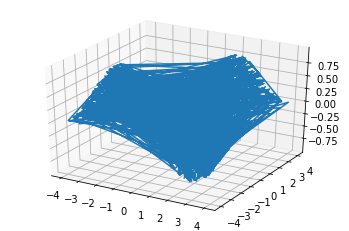

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=x1, ys=x2, zs=y)

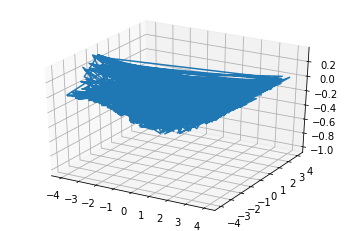

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=x1, ys=x2, zs=y_)

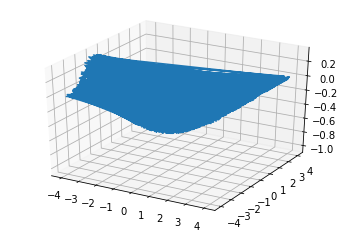

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=xtrain[:,0], ys=xtrain[:,1], zs=y_trainPredict)

In [24]:
#RMSE error value
np.linalg.norm(y-y_)/len(y)

0.0149964519587534

In [25]:
np.linalg.norm(ytrain-y_trainPredict)/len(ytrain)

0.006662682536026051

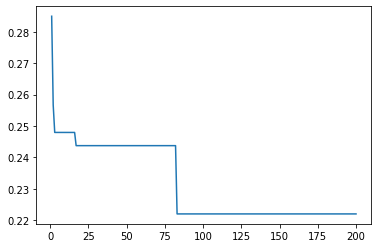

In [27]:
plt.plot(list(range(1,201)), costs)

Plot of how the cost function (RMSE value) varies over generation

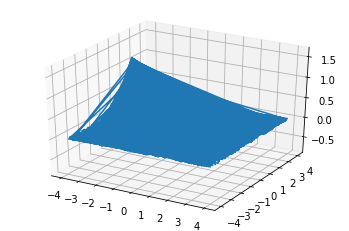

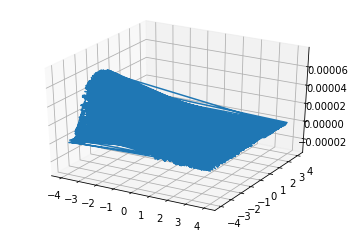

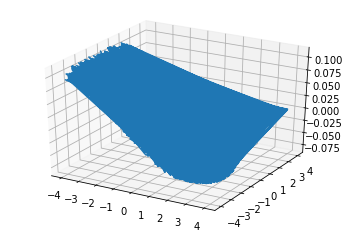

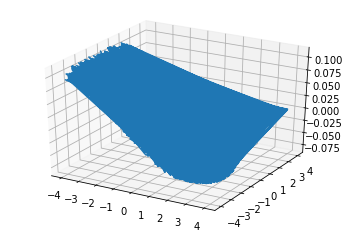

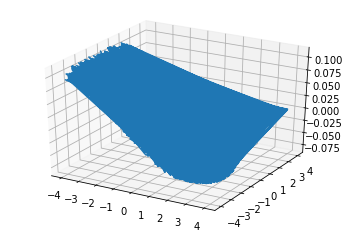

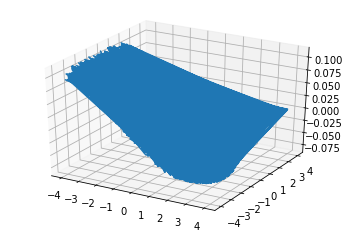

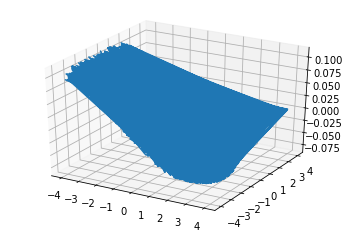

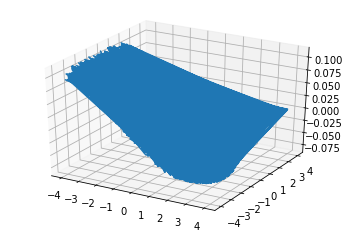

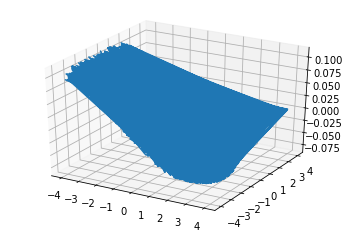

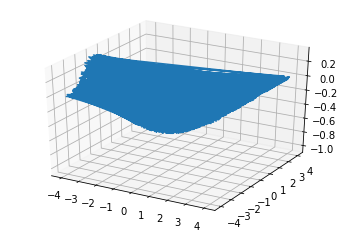

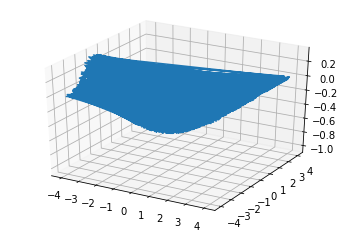

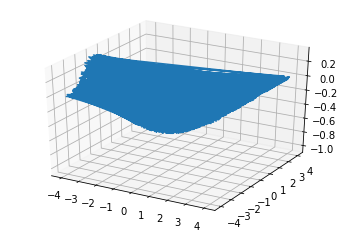

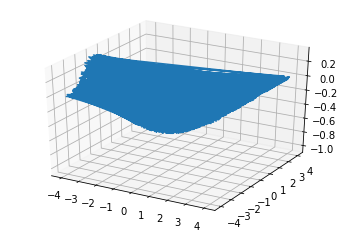

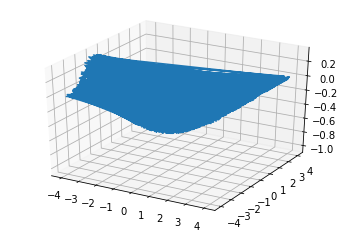

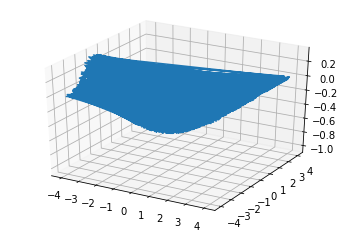

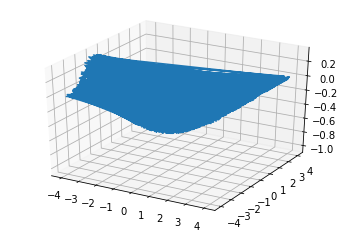

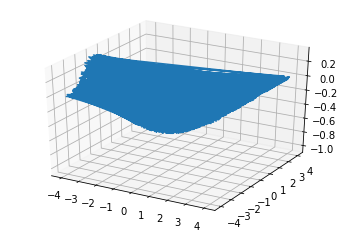

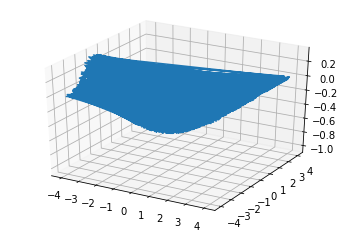

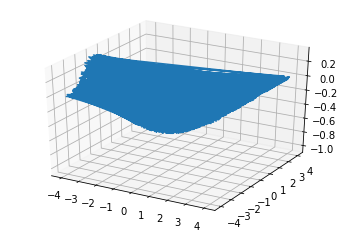

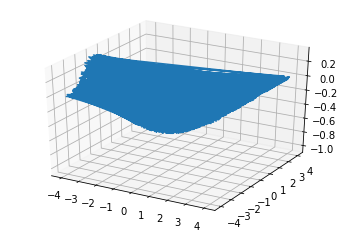

In [28]:

x1 = xtrain[:,0]
x2 = xtrain[:,1]
for i,params in enumerate(cache):
    if i%10!=0:
        continue
    y, _ = forwardPropagation(x1,x2,convertParams2dic(params))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    tmp = ax.plot(xs=x1, ys=x2, zs=y)
    #plt.savefig("images/image"+str(i)+".jpg")


In [51]:
k = [1,-1,2,-2]
l = [3,-3,4,-4]
crossover(k,l, nvar=4)

([0.44, -3.0, 4.0, -4.56], [3.56, -1.0, 2.0, -1.44])

In [70]:
mutation(k, nvar=4)

[3.91, 5.83, 11.02, -8.58]

In [34]:
np.random.rand(5)*2-1

array([-0.63284868,  0.82004607, -0.77102266,  0.21920675, -0.59011497])

In [29]:
np.random.randn?